## ---- Description: This program predicts employee attrition----


Objective : Minize employee Attrition
Constraint: Maximize Employee Satisfaction

Improvements: In this Version, following are the improvements:

a. SMOTE analysis done for oversampling of data
b. Feature Selection done using both information gain and chi-square test and results compared. In old version, only information gain method was done and after model building, random forest method applied for feature selection.
c. this resulted in reducing number of columns to 24.
d. PCA gave 99.99 score at n_components=31. In the revised model, n_component=21 gives 99.39 and n_components=24 gives 100%
Its relative but we can now building model using more important features.

In [66]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Feature Selection
#from sklearn.preprocessing import LabelEncoder, MinMaxScaler # For Label Encoding, Standardization
from sklearn.feature_selection import mutual_info_classif            # For Feature Selection
from sklearn.feature_selection import SelectKBest, chi2              # For Feature Selection 
from sklearn.decomposition import PCA                                # PCA
from imblearn.over_sampling import SMOTE                             # For Oversampling

from sklearn.datasets import make_classification                     # For SMOTE
from collections import Counter 

#Model Building
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


# 1. EDA

In [67]:
emp_data=pd.read_csv("employee.csv")
emp_data.head()                   

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [68]:
# to see total number of rows and columns
emp_data.shape

(1470, 35)

In [69]:
# to get overview of features- names, amount of null values,data types
emp_data.info()

# conclusion: no null values. but both categorical and int columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [70]:
# to get the general distribution of data
emp_data.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [75]:
print("Environment Satisfaction \n", '*'* 50)
print("Unique Values: ",emp_data.EnvironmentSatisfaction.unique())
print("Value Counts:\n",emp_data.EnvironmentSatisfaction.value_counts(normalize=True))

print("Relationship Satisfaction \n", '*'* 50)
print("Unique Values: ",emp_data.RelationshipSatisfaction.unique())
print("Value Counts:\n",emp_data.RelationshipSatisfaction.value_counts(normalize=True))


Environment Satisfaction 
 **************************************************
Unique Values:  [2 3 4 1]
Value Counts:
 3    0.308163
4    0.303401
2    0.195238
1    0.193197
Name: EnvironmentSatisfaction, dtype: float64
Relationship Satisfaction 
 **************************************************
Unique Values:  [1 4 2 3]
Value Counts:
 3    0.312245
4    0.293878
2    0.206122
1    0.187755
Name: RelationshipSatisfaction, dtype: float64


#### Separating Object and int column data types

In [7]:
obj_emp_data=emp_data.select_dtypes(include="object")
obj_emp_data

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Yes,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes
1,No,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No
2,Yes,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes
3,No,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes
4,No,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No
...,...,...,...,...,...,...,...,...,...
1465,No,Travel_Frequently,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No
1466,No,Travel_Rarely,Research & Development,Medical,Male,Healthcare Representative,Married,Y,No
1467,No,Travel_Rarely,Research & Development,Life Sciences,Male,Manufacturing Director,Married,Y,Yes
1468,No,Travel_Frequently,Sales,Medical,Male,Sales Executive,Married,Y,No


In [8]:
int_emp_data=emp_data.select_dtypes(include='int64')
int_emp_data

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1102,1,2,1,1,2,94,3,2,...,1,80,0,8,0,1,6,4,0,5
1,49,279,8,1,1,2,3,61,2,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1373,2,2,1,4,4,92,2,1,...,2,80,0,7,3,3,0,0,0,0
3,33,1392,3,4,1,5,4,56,3,1,...,3,80,0,8,3,3,8,7,3,0
4,27,591,2,1,1,7,1,40,3,1,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,1,2061,3,41,4,2,...,3,80,1,17,3,3,5,2,0,3
1466,39,613,6,1,1,2062,4,42,2,3,...,1,80,1,9,5,3,7,7,1,7
1467,27,155,4,3,1,2064,2,87,4,2,...,2,80,1,6,0,3,6,2,0,3
1468,49,1023,2,3,1,2065,4,63,2,2,...,4,80,0,17,3,2,9,6,0,8


In [9]:
# to see how highly correlated data is. i.e. increase of one factor increases/decreases another.
emp_data.corr()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,0.010661,-0.001686,0.208034,NaN,-0.010145,0.010146,0.024287,0.029820,0.509604,...,0.053535,NaN,0.037510,0.680381,-0.019621,-0.021490,0.311309,0.212901,0.216513,0.202089
DailyRate,0.010661,1.000000,-0.004985,-0.016806,NaN,-0.050990,0.018355,0.023381,0.046135,0.002966,...,0.007846,NaN,0.042143,0.014515,0.002453,-0.037848,-0.034055,0.009932,-0.033229,-0.026363
DistanceFromHome,-0.001686,-0.004985,1.000000,0.021042,NaN,0.032916,-0.016075,0.031131,0.008783,0.005303,...,0.006557,NaN,0.044872,0.004628,-0.036942,-0.026556,0.009508,0.018845,0.010029,0.014406
Education,0.208034,-0.016806,0.021042,1.000000,NaN,0.042070,-0.027128,0.016775,0.042438,0.101589,...,-0.009118,NaN,0.018422,0.148280,-0.025100,0.009819,0.069114,0.060236,0.054254,0.069065
EmployeeCount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmployeeNumber,-0.010145,-0.050990,0.032916,0.042070,NaN,1.000000,0.017621,0.035179,-0.006888,-0.018519,...,-0.069861,NaN,0.062227,-0.014365,0.023603,0.010309,-0.011240,-0.008416,-0.009019,-0.009197
EnvironmentSatisfaction,0.010146,0.018355,-0.016075,-0.027128,NaN,0.017621,1.000000,-0.049857,-0.008278,0.001212,...,0.007665,NaN,0.003432,-0.002693,-0.019359,0.027627,0.001458,0.018007,0.016194,-0.004999
HourlyRate,0.024287,0.023381,0.031131,0.016775,NaN,0.035179,-0.049857,1.000000,0.042861,-0.027853,...,0.001330,NaN,0.050263,-0.002334,-0.008548,-0.004607,-0.019582,-0.024106,-0.026716,-0.020123
JobInvolvement,0.029820,0.046135,0.008783,0.042438,NaN,-0.006888,-0.008278,0.042861,1.000000,-0.012630,...,0.034297,NaN,0.021523,-0.005533,-0.015338,-0.014617,-0.021355,0.008717,-0.024184,0.025976
JobLevel,0.509604,0.002966,0.005303,0.101589,NaN,-0.018519,0.001212,-0.027853,-0.012630,1.000000,...,0.021642,NaN,0.013984,0.782208,-0.018191,0.037818,0.534739,0.389447,0.353885,0.375281


In [10]:
for i in emp_data.columns:
    print('*'*50)
    print(i,":",emp_data[i].unique())
 
  

**************************************************
Age : [41 49 37 33 27 32 59 30 38 36 35 29 31 34 28 22 53 24 21 42 44 46 39 43
 50 26 48 55 45 56 23 51 40 54 58 20 25 19 57 52 47 18 60]
**************************************************
Attrition : ['Yes' 'No']
**************************************************
BusinessTravel : ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
**************************************************
DailyRate : [1102  279 1373 1392  591 1005 1324 1358  216 1299  809  153  670 1346
  103 1389  334 1123 1219  371  673 1218  419  391  699 1282 1125  691
  477  705  924 1459  125  895  813 1273  869  890  852 1141  464 1240
 1357  994  721 1360 1065  408 1211 1229  626 1434 1488 1097 1443  515
  853 1142  655 1115  427  653  989 1435 1223  836 1195 1339  664  318
 1225 1328 1082  548  132  746  776  193  397  945 1214  111  573 1153
 1400  541  432  288  669  530  632 1334  638 1093 1217 1353  120  682
  489  807  827  871  665 1040 1420  240 1280  534 1456 

In [11]:
emp_data["Department"].unique()

array(['Sales', 'Research & Development', 'Human Resources'], dtype=object)

# 3. Data Visualization

<AxesSubplot:>

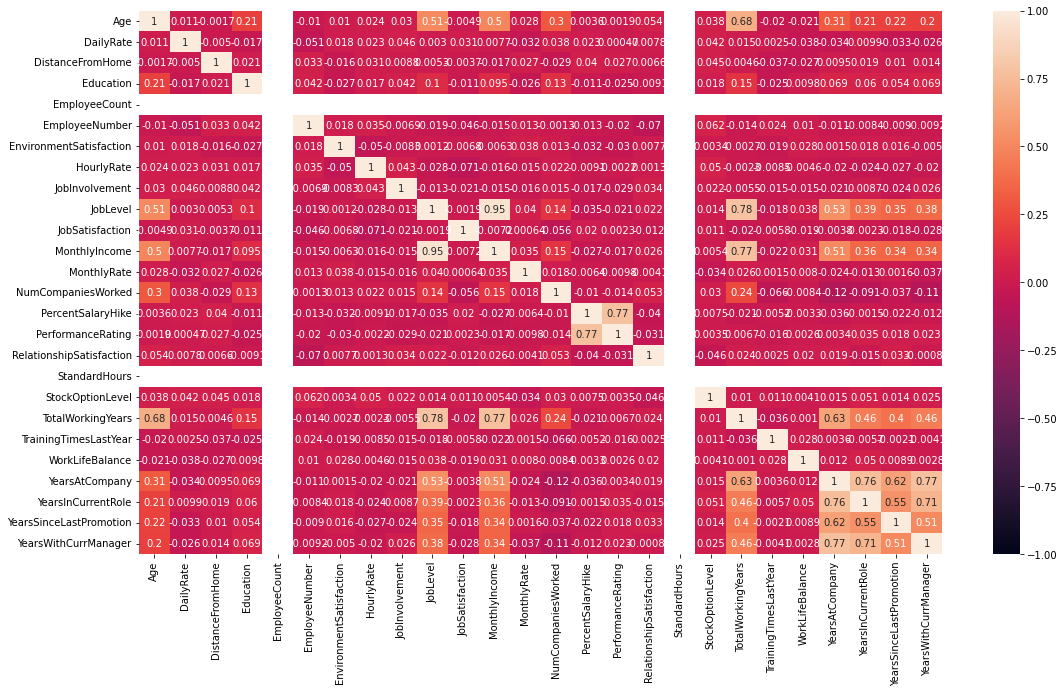

In [12]:
plt.figure(figsize=(18,10))
sns.heatmap(emp_data.corr(),annot=True, vmin=-1)

Text(0.5, 1.0, 'Comparison ')

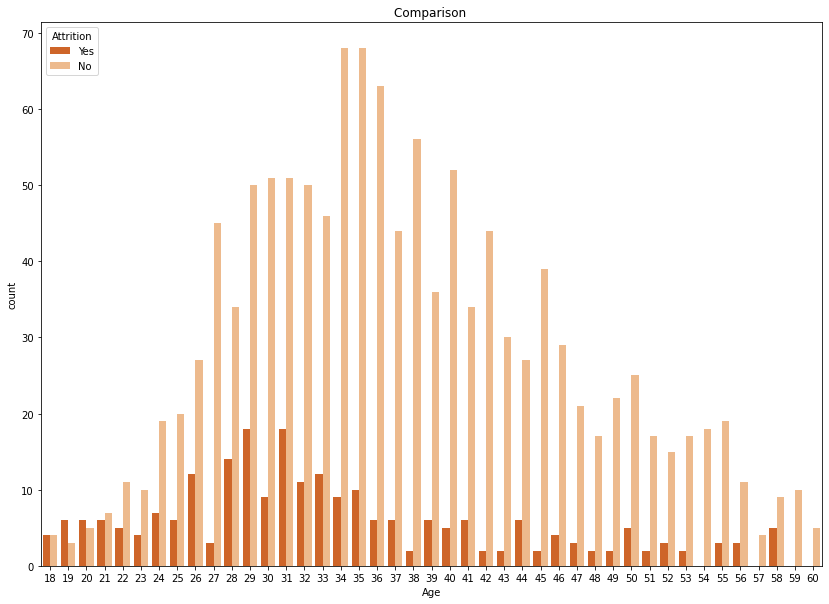

In [13]:
plt.figure(figsize=(14,10))
sns.countplot(x=emp_data['Age'],hue =emp_data['Attrition'],palette = 'Oranges_r' )
plt.title('Comparison ')
#plt.xticks(rotation='vertical')

<AxesSubplot:xlabel='OverTime', ylabel='count'>

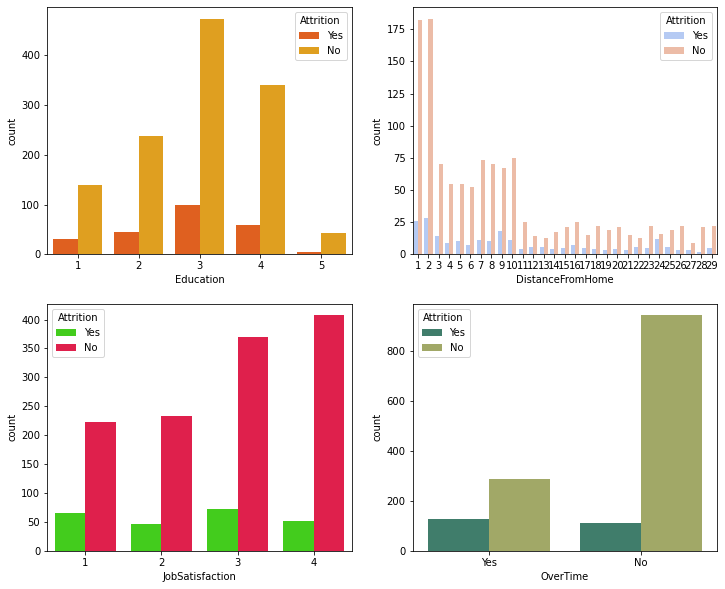

In [14]:
figure,axis= plt.subplots(2,2,figsize=(12,10))


sns.countplot(x=emp_data['Education'],hue=emp_data['Attrition'], ax=axis[0][0], palette='autumn')

sns.countplot(x=emp_data['DistanceFromHome'],hue='Attrition',data=emp_data,ax=axis[0][1],palette='coolwarm')

sns.countplot(x=emp_data['JobSatisfaction'],hue='Attrition',data=emp_data,ax=axis[1][0],palette='prism')
sns.countplot(x=emp_data['OverTime'],hue='Attrition',data=emp_data,ax=axis[1][1], palette='gist_earth')


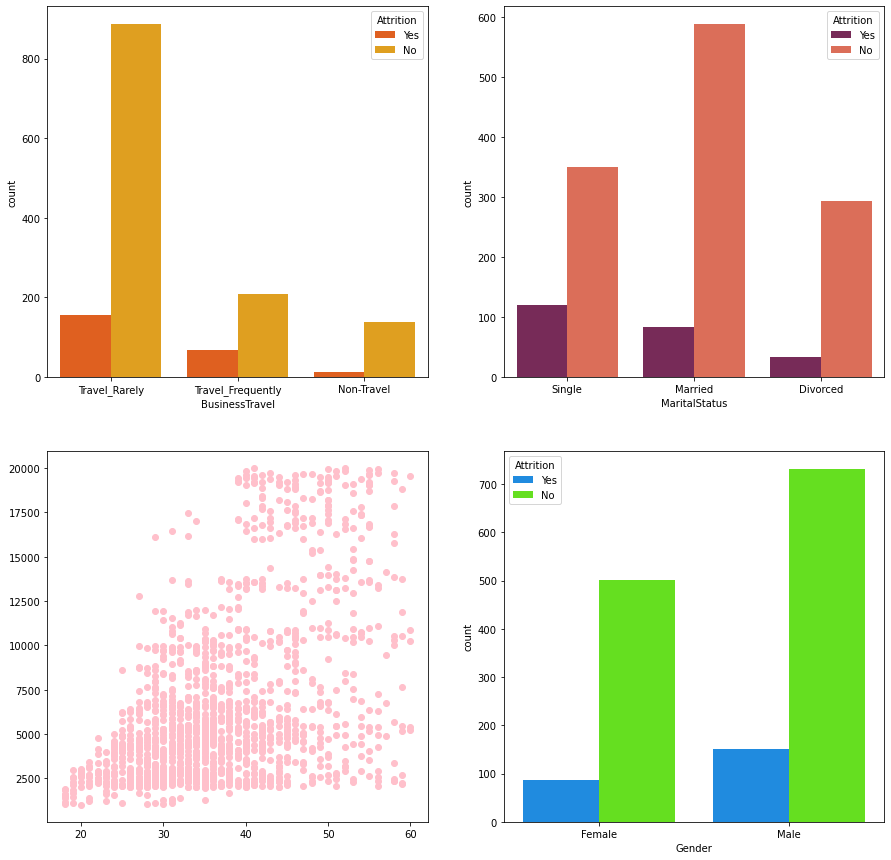

In [15]:
figure,axis= plt.subplots(2,2,figsize=(15,15))

x=emp_data['Age']
y=emp_data['MonthlyIncome']

sns.countplot(x=emp_data['BusinessTravel'],hue=emp_data['Attrition'], ax=axis[0][0],palette='autumn')
sns.countplot(x=emp_data['MaritalStatus'],hue='Attrition',data=emp_data,ax=axis[0][1], palette='rocket')
sns.countplot(x=emp_data['Gender'],hue='Attrition', data=emp_data,ax=axis[1][1],palette='gist_rainbow_r')
axis[1][0].scatter(x,y,marker='o',color='pink')

#figure.show()

<AxesSubplot:xlabel='YearsWithCurrManager'>

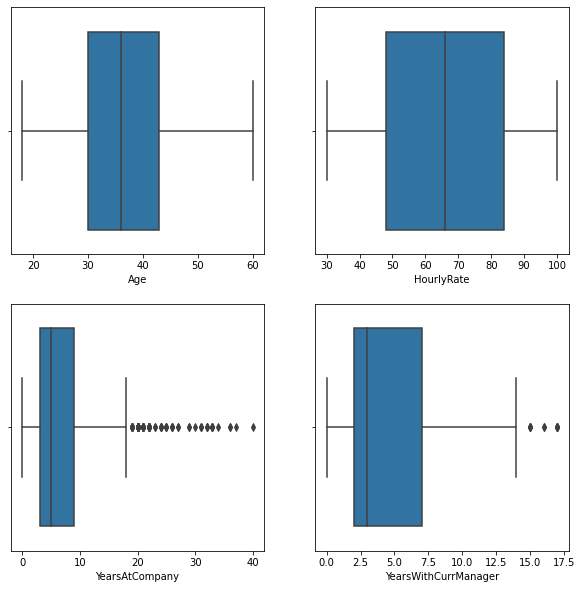

In [16]:
figure,axis=plt.subplots(2,2, figsize=(10,10))
sns.boxplot(x=emp_data['Age'],ax=axis[0][0])
sns.boxplot(x=emp_data['HourlyRate'],ax=axis[0][1])
sns.boxplot(x=emp_data['YearsAtCompany'],ax=axis[1][0])
sns.boxplot(x=emp_data['YearsWithCurrManager'],ax=axis[1][1])

<AxesSubplot:xlabel='MonthlyIncome', ylabel='Count'>

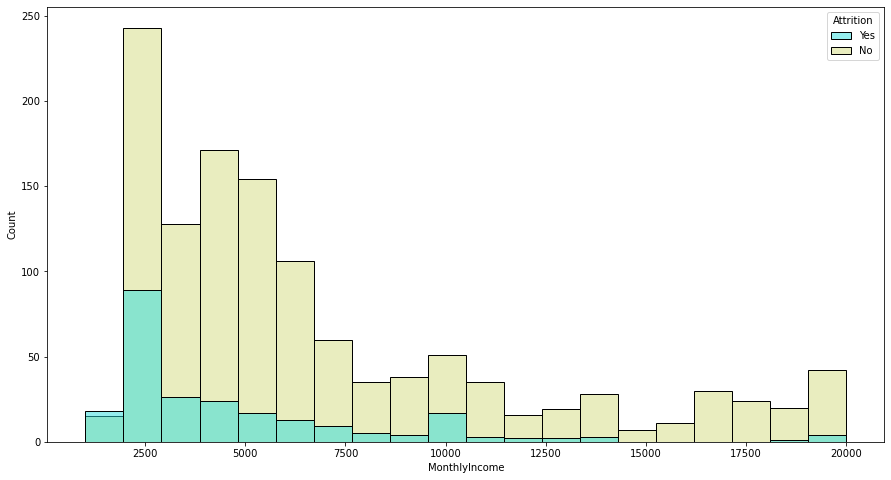

In [17]:
plt.figure(figsize=(15,8))
sns.histplot(x=emp_data['MonthlyIncome'],hue='Attrition',data=emp_data,palette="rainbow")

## 2. Feature Engineering

In [18]:
emp_data['EmployeeCount'].unique()

array([1], dtype=int64)

In [19]:
# Dropping columns with a single unique value
Target  = emp_data['Attrition']
emp_data=emp_data.drop(columns=['StandardHours', 'EmployeeCount','Over18','Attrition', 'EmployeeNumber', 'Over18'])


In [20]:
emp_data.corr()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,0.010661,-0.001686,0.208034,0.010146,0.024287,0.029820,0.509604,-0.004892,0.497855,...,0.001904,0.053535,0.037510,0.680381,-0.019621,-0.021490,0.311309,0.212901,0.216513,0.202089
DailyRate,0.010661,1.000000,-0.004985,-0.016806,0.018355,0.023381,0.046135,0.002966,0.030571,0.007707,...,0.000473,0.007846,0.042143,0.014515,0.002453,-0.037848,-0.034055,0.009932,-0.033229,-0.026363
DistanceFromHome,-0.001686,-0.004985,1.000000,0.021042,-0.016075,0.031131,0.008783,0.005303,-0.003669,-0.017014,...,0.027110,0.006557,0.044872,0.004628,-0.036942,-0.026556,0.009508,0.018845,0.010029,0.014406
Education,0.208034,-0.016806,0.021042,1.000000,-0.027128,0.016775,0.042438,0.101589,-0.011296,0.094961,...,-0.024539,-0.009118,0.018422,0.148280,-0.025100,0.009819,0.069114,0.060236,0.054254,0.069065
EnvironmentSatisfaction,0.010146,0.018355,-0.016075,-0.027128,1.000000,-0.049857,-0.008278,0.001212,-0.006784,-0.006259,...,-0.029548,0.007665,0.003432,-0.002693,-0.019359,0.027627,0.001458,0.018007,0.016194,-0.004999
HourlyRate,0.024287,0.023381,0.031131,0.016775,-0.049857,1.000000,0.042861,-0.027853,-0.071335,-0.015794,...,-0.002172,0.001330,0.050263,-0.002334,-0.008548,-0.004607,-0.019582,-0.024106,-0.026716,-0.020123
JobInvolvement,0.029820,0.046135,0.008783,0.042438,-0.008278,0.042861,1.000000,-0.012630,-0.021476,-0.015271,...,-0.029071,0.034297,0.021523,-0.005533,-0.015338,-0.014617,-0.021355,0.008717,-0.024184,0.025976
JobLevel,0.509604,0.002966,0.005303,0.101589,0.001212,-0.027853,-0.012630,1.000000,-0.001944,0.950300,...,-0.021222,0.021642,0.013984,0.782208,-0.018191,0.037818,0.534739,0.389447,0.353885,0.375281
JobSatisfaction,-0.004892,0.030571,-0.003669,-0.011296,-0.006784,-0.071335,-0.021476,-0.001944,1.000000,-0.007157,...,0.002297,-0.012454,0.010690,-0.020185,-0.005779,-0.019459,-0.003803,-0.002305,-0.018214,-0.027656
MonthlyIncome,0.497855,0.007707,-0.017014,0.094961,-0.006259,-0.015794,-0.015271,0.950300,-0.007157,1.000000,...,-0.017120,0.025873,0.005408,0.772893,-0.021736,0.030683,0.514285,0.363818,0.344978,0.344079


<AxesSubplot:>

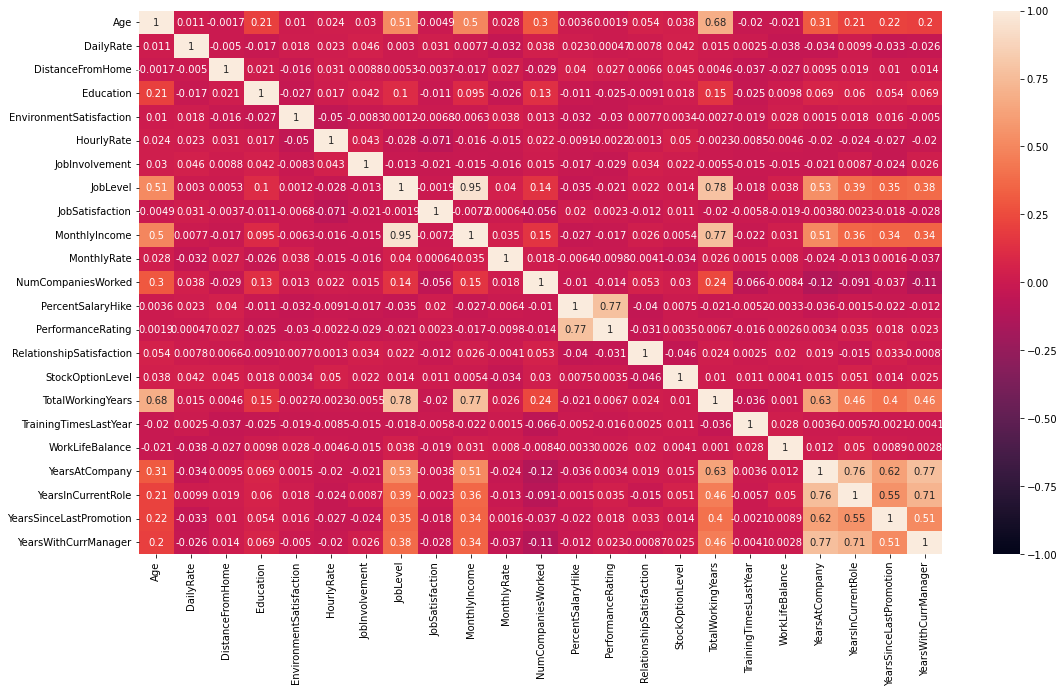

In [21]:
plt.figure(figsize=(18,10))
sns.heatmap(emp_data.corr(),annot=True, vmin=-1)

### Encoding

In [22]:
# Experemintal code- To be deleted
#for i in emp_data.columns:
 #   if(emp_data[i].dtype=='O'):
#int_emp_data=emp_data.select_dtypes(include='int64')
 #       print(i , emp_data[i].unique(), sep='  --  ')
  #      print(i, '\n', emp_data[i].value_counts(normalize=True).to_dict())
   # print("*"*10)
    
    

In [23]:
# Frequency Encoding using Value_counts()
# Alternate method, same effeciency: emp_data[cols].groupby(cols).size()/len(emp_data)
import time

begin=time.time()
for cols in emp_data.columns:
    column_name = emp_data[cols]
    if emp_data[cols].dtype=='O' :
        val_count = emp_data[cols].value_counts().to_dict()
        emp_data[cols]=emp_data[cols].map(val_count)
        print (cols, emp_data[cols], sep='--')
        print('\n')
end=time.time()

print("Time Taken is:", round(end-begin, 2)) #takes .03 seconds

BusinessTravel--0       1043
1        277
2       1043
3        277
4       1043
        ... 
1465     277
1466    1043
1467    1043
1468     277
1469    1043
Name: BusinessTravel, Length: 1470, dtype: int64


Department--0       446
1       961
2       961
3       961
4       961
       ... 
1465    961
1466    961
1467    961
1468    446
1469    961
Name: Department, Length: 1470, dtype: int64


EducationField--0       606
1       606
2        82
3       606
4       464
       ... 
1465    464
1466    464
1467    606
1468    464
1469    464
Name: EducationField, Length: 1470, dtype: int64


Gender--0       588
1       882
2       882
3       588
4       882
       ... 
1465    882
1466    882
1467    882
1468    882
1469    882
Name: Gender, Length: 1470, dtype: int64


JobRole--0       326
1       292
2       259
3       292
4       259
       ... 
1465    259
1466    131
1467    145
1468    326
1469    259
Name: JobRole, Length: 1470, dtype: int64


MaritalStatus--0       470
1    

In [24]:
emp_data.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1043,1102,446,1,2,606,2,588,94,...,3,1,0,8,0,1,6,4,0,5
1,49,277,279,961,8,1,606,3,882,61,...,4,4,1,10,3,3,10,7,1,7
2,37,1043,1373,961,2,2,82,4,882,92,...,3,2,0,7,3,3,0,0,0,0
3,33,277,1392,961,3,4,606,4,588,56,...,3,3,0,8,3,3,8,7,3,0
4,27,1043,591,961,2,1,464,1,882,40,...,3,4,1,6,3,3,2,2,2,2


# Normalization of data

In [25]:
#Normalizing data to bring data in the range of -1 to +1

def normalize(data):
    std_deviation= (data- data.min())/(data.max()-data.min())
    return std_deviation
emp_data = normalize(emp_data)

In [26]:
emp_data.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.547619,1.000000,0.715820,0.426503,0.000000,0.25,1.000000,0.333333,0.0,0.914286,...,0.0,0.000000,0.000000,0.200,0.0,0.000000,0.15,0.222222,0.000000,0.294118
1,0.738095,0.142217,0.126700,1.000000,0.250000,0.00,1.000000,0.666667,1.0,0.442857,...,1.0,1.000000,0.333333,0.250,0.5,0.666667,0.25,0.388889,0.066667,0.411765
2,0.452381,1.000000,0.909807,1.000000,0.035714,0.25,0.094991,1.000000,1.0,0.885714,...,0.0,0.333333,0.000000,0.175,0.5,0.666667,0.00,0.000000,0.000000,0.000000
3,0.357143,0.142217,0.923407,1.000000,0.071429,0.75,1.000000,1.000000,0.0,0.371429,...,0.0,0.666667,0.000000,0.200,0.5,0.666667,0.20,0.388889,0.200000,0.000000
4,0.214286,1.000000,0.350036,1.000000,0.035714,0.00,0.754750,0.000000,1.0,0.142857,...,0.0,1.000000,0.333333,0.150,0.5,0.666667,0.05,0.111111,0.133333,0.117647


# Data Balancing

In [27]:
# Checking the percentage of value distribution
Target.value_counts(normalize=True)

#Conclusion: Current ratio: 83/16, Expected ratio: 70/30


No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64

###                         OverSampling using SMOTE
 1. ARE WE NOT UNDERSAMPLING just BCOZ DATA SET IS SMALL?
 2. explain hyperparameters of below cell make_classification. removed n_features and n_classes

In [28]:
# removed n_features and n_classes.
X,Y = make_classification(class_sep=0.5, 
                          weights = [0.05,0.95],n_informative=2,
                          n_redundant = 0, flip_y=0, 
                          n_clusters_per_class=1, n_samples=10000,random_state=10)

In [29]:
X.shape, Y.shape

((10000, 20), (10000,))

In [30]:
X

array([[-1.12466537, -0.69345284, -0.18185381, ..., -1.33109376,
         1.18569883,  1.11142082],
       [-0.11428433,  0.72089559, -0.96268658, ...,  1.63635615,
        -0.50325488,  0.1005761 ],
       [-1.01145197,  1.56009197, -0.48312381, ..., -0.46260495,
        -0.18043176,  1.53489024],
       ...,
       [-1.90965475, -0.8681384 , -0.99154427, ..., -0.01403917,
         0.6569883 , -0.09277261],
       [-0.76456497,  0.50875358,  1.49691602, ..., -0.71878937,
        -0.36306695, -0.77328952],
       [-0.42129961, -0.48080609,  2.03130839, ...,  0.61004862,
        -0.55121098, -0.4421592 ]])

In [31]:
Y

array([1, 1, 1, ..., 1, 1, 1])

In [32]:
Counter(Y)

Counter({1: 9500, 0: 500})

In [33]:
sm= SMOTE(random_state=42)
sm_X, sm_Y = sm.fit_resample(X,Y)

In [34]:
#np.unique(sm_X[:,0], sm_Y[:,1],hue= sm_Y,alpha=0.5)
np.unique(sm_Y,return_counts=True)

(array([0, 1]), array([9500, 9500], dtype=int64))

In [35]:
sm_X.shape, sm_Y.shape

((19000, 20), (19000,))

C:\Users\shilp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

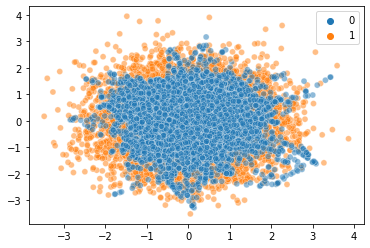

In [36]:
sns.scatterplot(sm_X[:,0], sm_X[:,1],hue= sm_Y,alpha=0.5)

### Feature Importance - CHECK

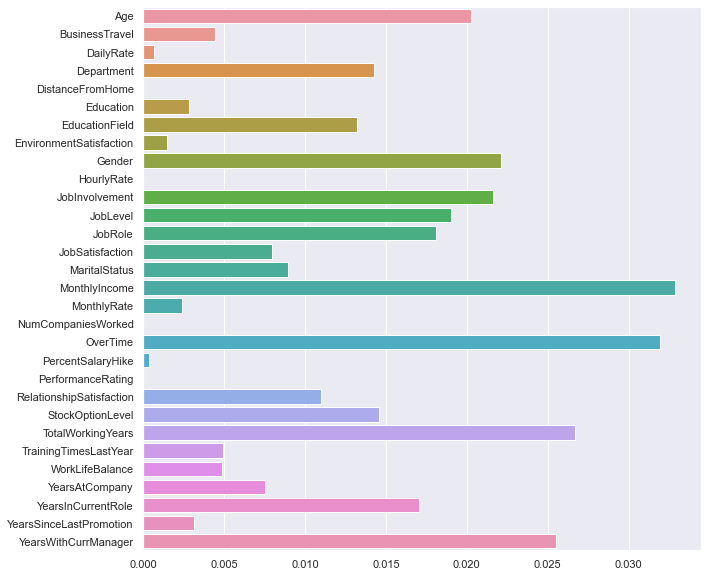

In [42]:
#1. Information Gain
importances= mutual_info_classif(emp_data,Target)
#fImp = pd.Series(importances, emp_data.columns)
x_imp=pd.Series(importances)
y_cols=pd.Series(emp_data.columns)

ax= sns.barplot(x=x_imp,y=y_cols)
sns.set(rc={"figure.figsize":(10,10)})
plt.show()

In [43]:
#method 2 using chi2
# Finding 10 best features
bestfeatures=SelectKBest(score_func=chi2,k=10)
x= emp_data.astype(np.uint8,errors='ignore')
y= Target.astype(np.uint8,errors='ignore')

#Apply SElectKBest class to extract top best features
fit=bestfeatures.fit(x,y)
emp_scores = pd.Series(fit.scores_)
emp_columns = pd.Series(x.columns)

#concat two dataframes for better visualization

featurescore = pd.concat([emp_columns,emp_scores], axis=1)
featurescore.columns=['Specs','Score']
featurescore.sort_values(by='Score',ascending=False)


,Specs,Score
18,OverTime,25.198812
23,TotalWorkingYears,10.405063
13,JobSatisfaction,7.798956
14,MaritalStatus,6.597586
10,JobInvolvement,5.359821
16,MonthlyRate,5.202532
26,YearsAtCompany,5.202532
11,JobLevel,4.019888
3,Department,3.702916
7,EnvironmentSatisfaction,2.350331


In [44]:
# CHECK
emp_data=emp_data.drop(columns=['PercentSalaryHike','PerformanceRating','YearsSinceLastPromotion','TrainingTimesLastYear',
                                'MonthlyRate','DailyRate'])
# Not dropping columns like education, relatiosnhip SAtisfaction, Worklifebalance as they look imp but chart not supporting.

In [45]:
#Determining shape
emp_data.shape

# Conclusion: The number of columns is still 24. We can reduce it.

(1470, 24)

# Feature Reduction using PCA

In [46]:
emp_data.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,MonthlyIncome,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager
0,0.547619,1.000000,0.426503,0.000000,0.25,1.000000,0.333333,0.0,0.914286,0.666667,...,0.262454,0.888889,0.0,0.000000,0.000000,0.200,0.000000,0.15,0.222222,0.294118
1,0.738095,0.142217,1.000000,0.250000,0.00,1.000000,0.666667,1.0,0.442857,0.333333,...,0.217009,0.111111,1.0,1.000000,0.333333,0.250,0.666667,0.25,0.388889,0.411765
2,0.452381,1.000000,1.000000,0.035714,0.25,0.094991,1.000000,1.0,0.885714,0.333333,...,0.056925,0.666667,0.0,0.333333,0.000000,0.175,0.666667,0.00,0.000000,0.000000
3,0.357143,0.142217,1.000000,0.071429,0.75,1.000000,1.000000,0.0,0.371429,0.666667,...,0.100053,0.111111,0.0,0.666667,0.000000,0.200,0.666667,0.20,0.388889,0.000000
4,0.214286,1.000000,1.000000,0.035714,0.00,0.754750,0.000000,1.0,0.142857,0.666667,...,0.129489,1.000000,1.0,1.000000,0.333333,0.150,0.666667,0.05,0.111111,0.117647


In [47]:
#Selecting PCA components
pca=PCA(n_components=21)
pca_values= pca.fit_transform(emp_data)
pca_values

array([[ 0.38620161, -0.71030375,  0.40811999, ...,  0.32844322,
        -0.06986021, -0.0297669 ],
       [-0.36436903,  0.30060704, -0.13973343, ..., -0.00469748,
         0.33389569,  0.00132619],
       [-0.51274545, -0.2921814 ,  0.74446001, ...,  0.12487089,
         0.06651207, -0.01291898],
       ...,
       [-0.21179849,  0.02748149,  0.56280231, ..., -0.09310719,
        -0.1984631 , -0.04552927],
       [-0.29871244,  0.34249206, -0.07491049, ...,  0.05639312,
         0.27495345, -0.06907848],
       [-0.43413513,  0.16616844, -0.39114364, ..., -0.16445763,
        -0.03145488,  0.02727221]])

In [48]:
# Variance
pca_var= pca.explained_variance_ratio_
print(pca_var)

[0.10879416 0.09836901 0.08736504 0.07671812 0.06775322 0.06095331
 0.0574563  0.05579475 0.0543243  0.04437353 0.03925025 0.03706788
 0.03408285 0.03251003 0.03088822 0.02589122 0.02363206 0.02279417
 0.01855937 0.01186853 0.00507719]


In [49]:
#Cumulative Variance

cum_var = np.cumsum(np.round(pca_var,decimals=4)*100)
print(cum_var)

[10.88 20.72 29.46 37.13 43.91 50.01 55.76 61.34 66.77 71.21 75.14 78.85
 82.26 85.51 88.6  91.19 93.55 95.83 97.69 98.88 99.39]


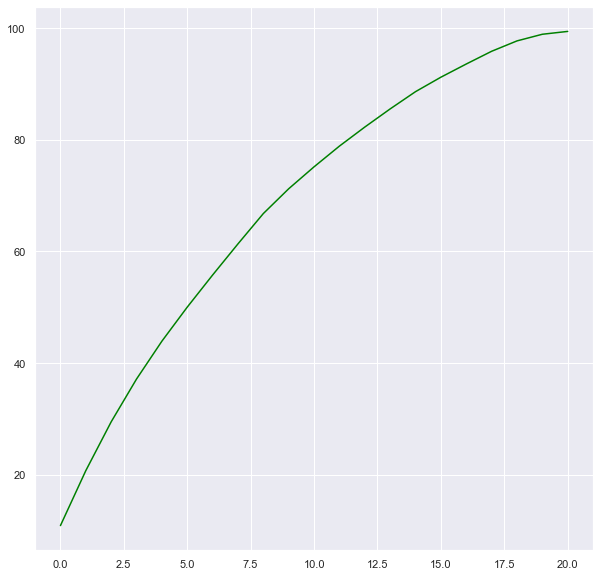

In [50]:
plt.plot(cum_var, color='green')
# Conclusion: The number of columns are not reduced much. 100% obtained at n_components=24. 


# Train Test split

In [51]:
#x_train,x_test,y_train,y_test=train_test_split(emp_data,Target, test_size=0.3)
x_train,x_test,y_train,y_test=train_test_split(sm_X,sm_Y, test_size=0.3)

# Model Building

### Random Forest

In [52]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)
rfc_ypred = rfc.predict(x_test)
accuracy_score(rfc_ypred, y_test)

0.9640350877192982

In [53]:
rfc.feature_importances_

array([0.02765938, 0.02752771, 0.02820749, 0.14023225, 0.02398366,
       0.0275597 , 0.02665661, 0.0322041 , 0.02968321, 0.03033084,
       0.02716317, 0.0233568 , 0.36595014, 0.02553388, 0.02450042,
       0.0281885 , 0.02445099, 0.02858658, 0.02786354, 0.03036102])

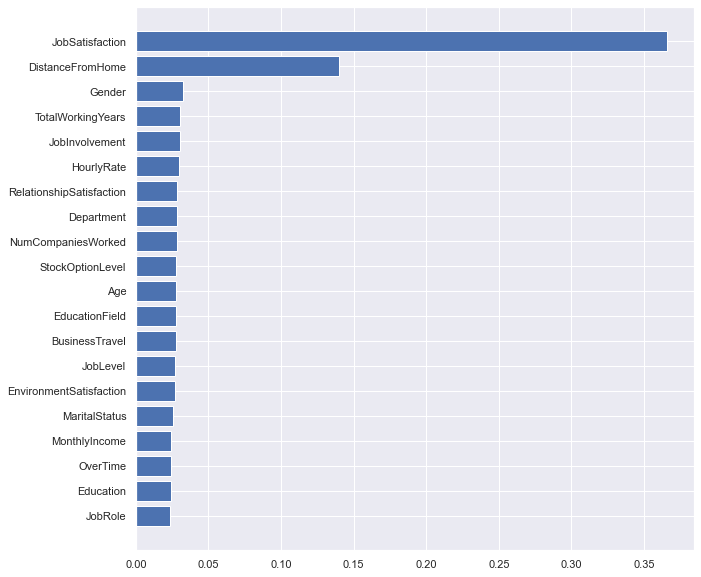

In [54]:
features =  emp_data.columns
importances = rfc.feature_importances_
indices= np.argsort(importances)

plt.figure(figsize=(10,10))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()

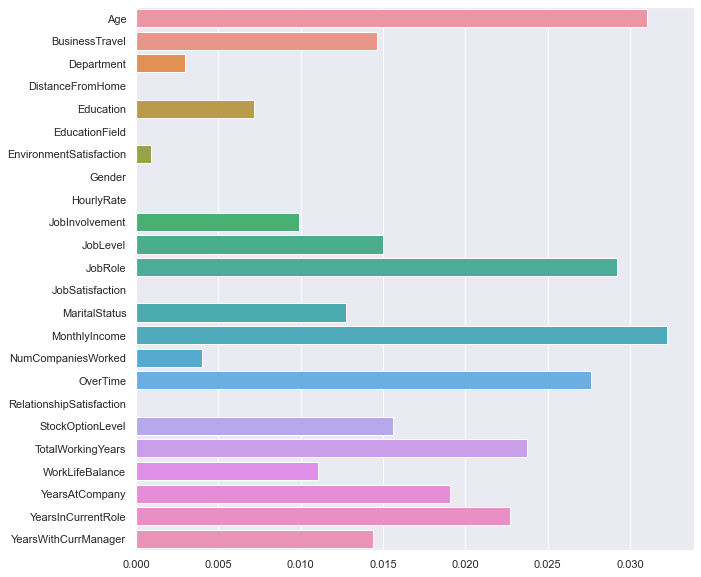

In [55]:
#1. Information Gain
importances= mutual_info_classif(emp_data,Target)
#fImp = pd.Series(importances, emp_data.columns)
x_imp=pd.Series(importances)
y_cols=pd.Series(emp_data.columns)

ax= sns.barplot(x=x_imp,y=y_cols)
sns.set(rc={"figure.figsize":(10,10)})
plt.show()